In [62]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet152
from torchvision.transforms import v2
from torch.utils.data import DataLoader


# seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [63]:
# model
model = resnet152(pretrained=True)
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")
labels = [366, 355, 312, 261, 298]

/home/yanai-lab/kanayama-r/.conda/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yanai-lab/kanayama-r/.conda/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
'''
課題6
Deep Dream
'''

img_idx = 3
o_img = read_image(img_paths[img_idx])
label = labels[img_idx]

In [65]:
class DeepDream:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.activation = None
        # forward hook
        target_layer.register_forward_hook(
            lambda m,inp,out: setattr(self, 'activation', out)
        )

    def dream(self, img, iterations=20, lr=0.001):
        img = img.clone().detach().requires_grad_(True)
        optimizer = torch.optim.Adam([img], lr=lr)

        for _ in range(iterations):
            optimizer.zero_grad()
            _ = self.model(img)
            score = self.activation.norm()
            score.backward()
            optimizer.step()

        return img.detach().cpu()


/home/yanai-lab/kanayama-r/.conda/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:80: FutureWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  return comm.gather(inputs, ctx.dim, ctx.target_device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5589988..2.8507383].


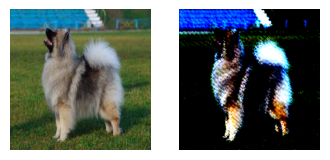

In [66]:
# exp
transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1).unsqueeze(0)
img_2.to(device)

target_layer = model.module.layer1[-1].conv3

deep_dream = DeepDream(
    model,
    target_layer
)
dreamed = deep_dream.dream(img_2, iterations=30, lr=0.02)

# 可視化
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(dreamed.squeeze(0).permute(1,2,0))